## K-Means

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline 
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#from sklearn import cross_validation, linear_model
from sklearn.model_selection import cross_validate
from sklearn.cluster import KMeans
from sklearn import datasets
import random
import time
from kneed import KneeLocator
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_parquet('./Firebase/user_track_df.parquet', engine='pyarrow')
df.head()

,user_id,song_id,listen_count,track_id,artist_name,track_name,track_uri,popularity,duration_ms,explicit,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,artist_id
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,...,-8.176,0,0.0327,0.11900,0.000412,0.103,0.0396,126.051,4,4ssUf5gLb1GBLxi1BhPrVt
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRUATNS128F423457D,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,...,-7.858,0,0.1530,0.00564,0.000000,0.408,0.4900,103.992,4,5K4W6rqBFWDnAN6FQUkS6x
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,TRYBNIB128F428E704,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,...,-12.640,1,0.0355,0.46800,0.000043,0.117,0.4430,122.012,4,3GBPw9NK25X1Wt2OUvOwY3
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOEWFWM12A8C1308BA,1,TRLQPQJ128F42AA94F,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,...,-12.321,0,0.0653,0.29700,0.000267,0.127,0.9050,114.656,4,3jc496ljiyrS3ECrD7QiqL


In [3]:
#only taking 500000 rows for the sake of memory
df_kmeans = df.head(500000)

In [4]:
#dropping unnecessary columns
df_kmeans = df_kmeans.drop(['user_id', 'song_id', 'track_id', 'artist_id'], axis = 1)

In [5]:
#transforming release_date into separate columns
df_kmeans[["day", "month", "year"]] = df_kmeans["release_date"].str.split("-", expand = True)
df_kmeans = df_kmeans.drop(['release_date'], axis = 1)

In [6]:
#checking if the transformation resulted in any null values
df_kmeans.isnull().any()

listen_count        False
artist_name         False
track_name          False
track_uri           False
popularity          False
duration_ms         False
explicit            False
danceability        False
energy              False
key                 False
loudness            False
mode                False
speechiness         False
acousticness        False
instrumentalness    False
liveness            False
valence             False
tempo               False
time_signature      False
day                 False
month                True
year                 True
dtype: bool

In [7]:
#dropping null values
df_kmeans = df_kmeans.dropna()

/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warni

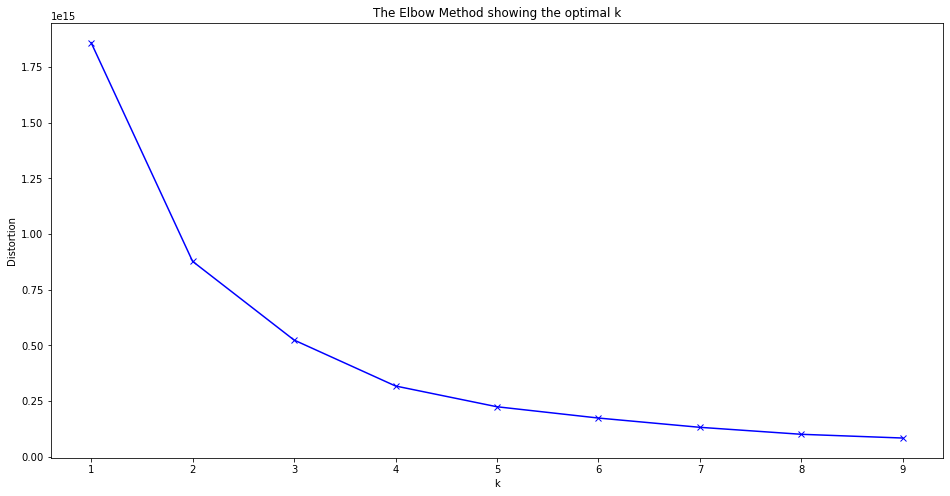

In [8]:
#finding the optimal number of clusters using elbow method
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [27]:
kl = KneeLocator(range(1, 10), distortions, curve="convex", direction="decreasing")

In [29]:
kl.elbow

3

In [30]:
#fitting the K-means model
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']])

/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3)

In [31]:
#printing labels
print(kmeans_model.labels_[:10], '\n\n', min(kmeans_model.labels_), max(kmeans_model.labels_))

[2 2 2 1 1 2 2 2 1 1] 

 0 2


In [32]:
#adding a column with the corresponding clusters
df_kmeans['type'] = kmeans_model.labels_
df_kmeans.head()

,listen_count,artist_name,track_name,track_uri,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,day,month,year,type
0,2,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,0.607,0.504,0,...,0.11900,0.000412,0.103,0.0396,126.051,4,2006,09,18,2
1,1,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,0.617,0.717,10,...,0.00564,0.000000,0.408,0.4900,103.992,4,2007,09,11,2
2,1,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,0.617,0.717,10,...,0.00564,0.000000,0.408,0.4900,103.992,4,2007,09,11,2
3,1,Jack Johnson,Constellations,3deZQXBY8CJFbrTc2PbU34,59,201640,0,0.705,0.316,1,...,0.46800,0.000043,0.117,0.4430,122.012,4,2005,01,01,1
4,1,Gipsy Kings,Soy,076jKe7yfP979o1QLKMIA2,47,189987,0,0.643,0.880,1,...,0.29700,0.000267,0.127,0.9050,114.656,4,1989,05,01,1


In [33]:
ids = input('Enter comma-separated ids of your favorite songs\n> ').strip().split(',')
# sample input: 1xK1Gg9SxG8fy2Ya373oqb,1xQ6trAsedVPCdbtDAmk0c,7ytR5pFWmSjzHJIeQkgog4,079Ey5uxL04AKPQgVQwx5h,0lizgQ7Qw35od7CYaoMBZb,7r9ZhitdQBONTFOiJW5mr8,3ee8Jmje8o58CHK66QrVC2,3ZG8N7aWw2meb6UrI5ZmnZ,5cpJFiNwYyWwFLH0V6B3N8,26w9NTiE9NGjW1ZvIOd1So,7BIy3EGQhg98CsRdKYHnJC,2374M0fQpWi3dLnB54qaLX,2IVsRhKrx8hlQBOWy4qebo,40riOy7x9W7GXjyGp4pjAv,4evmHXcjt3bTUHD1cvny97,0MF5QHFzTUM2dYm6J7Vngt,0TrPqhAMoaKUFLR7iYDokf,07KXEDMj78x68D884wgVEm,6gxKUmycQX7uyMwJcweFjp

# search the specified ids in this dataset and get the tracks
favorites = df_kmeans[df_kmeans.track_uri.isin(ids)]

# code to sort find out the maximum occuring cluster number according to user's favorite track types
cluster_numbers = list(favorites['type'])
clusters = {}
for num in cluster_numbers:
    clusters[num] = cluster_numbers.count(num)

# sort the cluster numbers and find out the number which occurs the most
user_favorite_cluster = [(k, v) for k, v in sorted(clusters.items(), key=lambda item: item[1])][0][0]

print('\nFavorite cluster:', user_favorite_cluster, '\n')

# finally get the tracks of that cluster
suggestions = df_kmeans[df_kmeans.type == user_favorite_cluster]

# now print the first 5 rows of the data frame having that cluster number as their type
suggestions.head()

Enter comma-separated ids of your favorite songs
> 2ECKXkpPAxky87ohawpaeD

Favorite cluster: 2 



,listen_count,artist_name,track_name,track_uri,popularity,duration_ms,explicit,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,day,month,year,type
0,2,Jorge Drexler,12 segundos de oscuridad,2ECKXkpPAxky87ohawpaeD,37,246826,0,0.607,0.504,0,...,0.11900,0.000412,0.103,0.0396,126.051,4,2006,09,18,2
1,1,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,0.617,0.717,10,...,0.00564,0.000000,0.408,0.4900,103.992,4,2007,09,11,2
2,1,Kanye West,Stronger,4fzsfWzRhPawzqhX8Qt9F3,82,311867,1,0.617,0.717,10,...,0.00564,0.000000,0.408,0.4900,103.992,4,2007,09,11,2
5,1,Foo Fighters,Stacked Actors,1vziI0NCJKrqKiG94COHBa,55,256440,0,0.502,0.934,7,...,0.00203,0.001020,0.234,0.6700,134.898,4,1999,11,02,2
6,1,John Mayer,Clarity,6atVS7UZBxoyJkkteM62u5,59,271427,0,0.666,0.713,2,...,0.17200,0.032000,0.177,0.4910,94.710,4,2003,09,09,2


In [41]:
 # Instantiate k-means and dbscan algorithms
kmeans = KMeans(n_clusters=3)
#dbscan = DBSCAN(eps=0.3)

# Fit the algorithms to the features
kmeans.fit(df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']])
#dbscan.fit(df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']])

/Users/macbookpro16/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


DBSCAN(eps=0.3)

In [43]:
# Compute the silhouette scores for each algorithm
kmeans_silhouette = silhouette_score(
     df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']], 
     kmeans.labels_
 ).round(2)
#dbscan_silhouette = silhouette_score(
 #   df_kmeans[['listen_count', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'day', 'month', 'year']],
  #  dbscan.labels_
 #).round (2)

In [44]:
kmeans_silhouette

0.52